In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import time
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
import scipy as sp
from sklearn.manifold import MDS
pd.set_option('display.max_columns', None)

In [2]:
data = pd.read_csv('data/filtered_embryo_data.csv')
data = data.loc[~data.cell_index.isin([ 80.,  84., 105., 113.])] #getting rid of cells with less than 150 reads
cell_id_to_id = {}
id_to_cell_id = {}
cell_indeces = data.cell_index.unique()
for i,cell_id in enumerate(cell_indeces):
    cell_id_to_id[cell_id] = i
    id_to_cell_id[i] = cell_id 
    print(i, cell_id, data.loc[data.cell_index==cell_id, 'stage'].unique()[0])

0 1 zygote
1 2 zygote
2 3 zygote
3 4 zygote
4 5 zygote
5 6 zygote
6 7 zygote
7 8 zygote
8 9 zygote
9 10 zygote
10 11 zygote
11 12 zygote
12 13 zygote
13 14 zygote
14 15 zygote
15 16 zygote
16 17 zygote
17 18 zygote
18 19 zygote
19 20 zygote
20 21 zygote
21 22 zygote
22 23 zygote
23 24 zygote
24 25 2cell
25 26 2cell
26 27 2cell
27 28 2cell
28 29 2cell
29 30 2cell
30 31 2cell
31 32 2cell
32 33 2cell
33 34 2cell
34 35 2cell
35 36 2cell
36 37 2cell
37 38 2cell
38 39 2cell
39 40 2cell
40 41 2cell
41 42 2cell
42 43 2cell
43 44 2cell
44 45 2cell
45 46 2cell
46 47 2cell
47 48 2cell
48 49 2cell
49 50 2cell
50 51 2cell
51 52 2cell
52 53 2cell
53 54 2cell
54 55 2cell
55 56 2cell
56 57 2cell
57 58 2cell
58 59 2cell
59 60 2cell
60 61 2cell
61 62 2cell
62 63 2cell
63 64 2cell
64 65 4cell
65 66 4cell
66 67 4cell
67 68 4cell
68 69 4cell
69 70 4cell
70 71 4cell
71 72 4cell
72 73 4cell
73 74 4cell
74 75 4cell
75 76 4cell
76 77 4cell
77 78 4cell
78 79 4cell
79 81 4cell
80 82 4cell
81 83 4cell
82 85 4cell

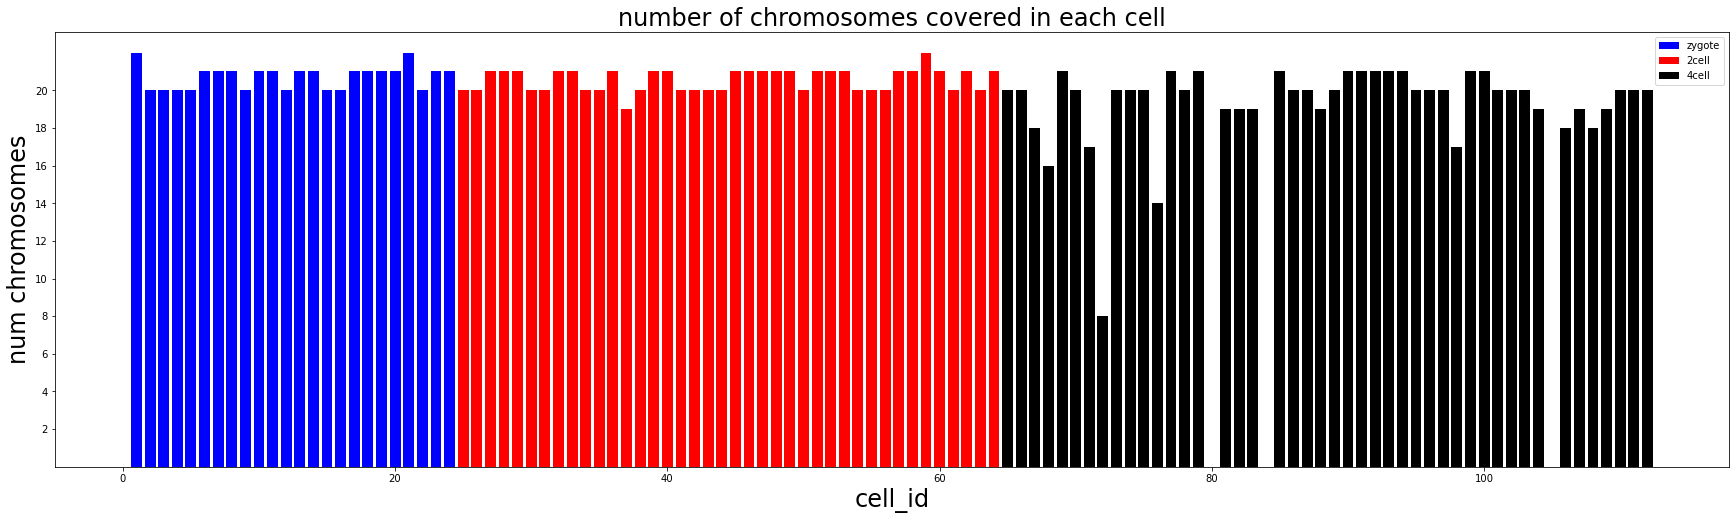

In [3]:
cells = np.array(data.cell_index.unique())
stages = np.array(cells).astype(str)
num_chromosomes = np.zeros_like(cells)
for i,cell_id in enumerate(cells):
    num_chromosomes[i] = data.loc[data.cell_index==cell_id, 'chr'].unique().shape[0]
    stages[i] = data.loc[data.cell_index==cell_id, 'stage'].unique()[0]

plt.figure(figsize = (30,8))
plt.bar(cells[stages=='zygote'], num_chromosomes[stages=='zygote'], color = 'blue', label = "zygote")
plt.bar(cells[stages=='2cell'], num_chromosomes[stages=='2cell'], color = 'red', label = "2cell")
plt.bar(cells[stages=='4cell'], num_chromosomes[stages=='4cell'], color = 'black', label = "4cell")

plt.xlabel("cell_id", fontsize = 24)
plt.ylabel("num chromosomes", fontsize = 24)
plt.title("number of chromosomes covered in each cell", fontsize = 24)
plt.legend()
plt.yticks(np.arange(2,21,2))
plt.savefig("figures/num_chromosomes_distribution_inlier.png")
plt.show()

In [38]:
data['nunique_cluster'] = data.groupby(['cell_index','chr']).cluster.transform('nunique')

In [57]:
np.mean(data.loc[(data.stage=='zygote') & (data.chr < 22)].groupby(['cell_index','chr_territory']).cluster_hap_imputed.mean() == -1)
        
        

0.0020964360587002098

In [115]:
"""if we haplotype assignment use the means.
   otherwise, if we have two distinct clusters, use mean
   otherwise: if cluster value is -1, use average for both rows (alternative would be to use NAN)
NOTE: for the territories W/O parental assignment but WITH cluster assignment, the row-pairs are unordered. 
Meaning, if for cell 1, row 1 is chr1M and row 2 is chr1P, it could be that for 
other cells, row1 is chr1P, and row 2 is chr1M"""
def get_homolog_resolved_dist_mat(cell_data_mat): #returns a 19*2 x 19*2 distance matrix
    centers = np.empty((19*2,3)) #row index i = 2*(chr_n-1)+(cluster)
    centers[:] = np.nan
    
    chr_nums = np.arange(1,20) #all autosome chromosome numbers [1,19]
   
    #get chromosome centers
    for chr_n in chr_nums:
        chrom = cell_data_mat.loc[cell_data_mat.chr==chr_n]
        if len(chrom)==0: continue #if the chr is not in this cell, we leave it as NAN
        
        hap_clusters = chrom.cluster_hap_imputed.unique()
       
        assert np.all(np.isin(hap_clusters,[-1,0,1])) #0: maternal, 1: paternal
        
        if np.all(np.isin(hap_clusters,[0,1])): #if the chromosome territories have parental assignment
            for cl in [0,1]:
                i = 2*(chr_n-1)+ cl
                cluster = chrom.loc[chrom.cluster_hap_imputed==cl]
                centers[i,0] = cluster.x_um_abs.mean()
                centers[i,1] = cluster.y_um_abs.mean()
                centers[i,2] = cluster.z_um_abs.mean()
        elif np.all(np.isin(hap_clusters,[-1])): #if we the territories have no parental assinment but still have cluster assignment
            if np.all(np.isin(chrom.cluster.unique(),[1,2])):
                for cl in [1,2]:
                    i = 2*(chr_n-1)+(cl-1)
                    cluster = chrom.loc[chrom.cluster==cl]
                    centers[i,0] = cluster.x_um_abs.mean()
                    centers[i,1] = cluster.y_um_abs.mean()
                    centers[i,2] = cluster.z_um_abs.mean()
            elif np.all(np.isin(chrom.cluster.unique(),[-1])):
                cluster = chrom.loc[chrom.cluster==-1]
                i = 2*(chr_n-1)
                # we fill rows i and i+1 with the mean position of the chromosome
                centers[i:i+2,0] = cluster.x_um_abs.mean()
                centers[i:i+2,1] = cluster.y_um_abs.mean()
                centers[i:i+2,2] = cluster.z_um_abs.mean()
       
    dist_mat = sp.spatial.distance.cdist(centers,centers)
    return dist_mat

    
"""if we haplotype assignment use the means.
   otherwise, keep them as NANs """
def get_haplotype_resolved_dist_mat(cell_data_mat): #returns a 19*2 x 19*2 distance matrix: ordered by maternal vs paternal
    centers = np.empty((19*2,3)) #row index i = 2*(chr_n-1)+(cluster)
    centers[:] = np.nan
    
    chr_nums = np.arange(1,20) #all autosome chromosome numbers [1,19]
   
    #get chromosome centers
    for chr_n in chr_nums:
        chrom = cell_data_mat.loc[cell_data_mat.chr==chr_n]
        if len(chrom)==0: continue #if the chr is not in this cell, we leave it as NAN
        
        hap_clusters = chrom.cluster_hap_imputed.unique()
       
        assert np.all(np.isin(hap_clusters,[-1,0,1])) #0: maternal, 1: paternal
        for cl in [0,1]:
            i = 2*(chr_n-1)+ cl
            cluster = chrom.loc[chrom.cluster_hap_imputed==cl]
            centers[i,0] = cluster.x_um_abs.mean()
            centers[i,1] = cluster.y_um_abs.mean()
            centers[i,2] = cluster.z_um_abs.mean()
       
    dist_mat = sp.spatial.distance.cdist(centers,centers)
    return dist_mat

##Nan will corresppond to a missing chromosome, or trisomy chromosome, or when only one copy is available, etc...
def get_chr_average_dist_mat(cell_data_mat): #returns a 19 x 19 distance matrix: 
    centers = np.empty((19*2,3)) #row index i = 2*(chr_n-1)+(cluster)
    centers[:] = np.nan
    
    chr_nums = np.arange(1,20) #all autosome chromosome numbers [1,19]
   
    #make array to hold the xyz positions of the centers of the bins
    centers = np.empty((len(chr_nums)*2,3))
    centers[:] = np.nan
    
    #get bin centers
    for chr_n in chr_nums:
        chrom = cell_data_mat.loc[cell_data_mat.chr==chr_n]
        clusters = chrom.cluster.unique()
        
        #if the chromosome is not present in the data, continue
        if len(clusters)==0:continue
                
        if np.all(np.isin(chrom.cluster.unique(),[1,2])):
            for cl in [1,2]:
                i = 2*(chr_n-1)+(cl-1)
                cluster = chrom.loc[chrom.cluster==cl]
                centers[i,0] = cluster.x_um_abs.mean()
                centers[i,1] = cluster.y_um_abs.mean()
                centers[i,2] = cluster.z_um_abs.mean()
        elif np.all(np.isin(chrom.cluster.unique(),[-1])):
            cluster = chrom.loc[chrom.cluster==-1]
            i = 2*(chr_n-1)
            # we fill rows i and i+1 with the mean position of the chromosome
            centers[i:i+2,0] = cluster.x_um_abs.mean()
            centers[i:i+2,1] = cluster.y_um_abs.mean()
            centers[i:i+2,2] = cluster.z_um_abs.mean()
    
    #calculate matrix of pairwise distances beteween centers of chromosome territories
    m=sp.spatial.distance.cdist(centers,centers)
    
    #aggregate distances for both homologs to be haplotype-agnostic
    evens=np.arange(0,m.shape[0],2,dtype=int)
    odds=np.arange(1,m.shape[0],2,dtype=int)
    m=m[:,evens]+m[:,odds]
    m=m[evens,:]+m[odds,:]
    
    #double the diagonal, because off-diagonal entries have been created through the sum of four distances,
    #while the diagonals have been created through the sum of two distances and two zeros
    diag_i=np.diag_indices(m.shape[0])
    m[diag_i]=m[diag_i]*2
    
    #divide the matrix by 4, since 4 measurements have been added to produce each entry
    m=m/4
    
    return m

def get_haplotype_and_chr_average_dist_mat(cell_data_mat): #returns a 19*2 x 19*2 distance matrix
    centers = np.empty((19*2,3)) #row index i = 2*(chr_n-1)+(cluster)
    centers[:] = np.nan
    
    chr_nums = np.arange(1,20) #all autosome chromosome numbers [1,19]
   
    #get chromosome centers
    for chr_n in chr_nums:
        chrom = cell_data_mat.loc[cell_data_mat.chr==chr_n]
        if len(chrom)==0: continue #if the chr is not in this cell, we leave it as NAN
        
        hap_clusters = chrom.cluster_hap_imputed.unique()
       
        assert np.all(np.isin(hap_clusters,[-1,0,1])) #0: maternal, 1: paternal
        
        if np.all(np.isin(hap_clusters,[0,1])): #if the chromosome territories have parental assignment
            for cl in [0,1]:
                i = 2*(chr_n-1)+ cl
                cluster = chrom.loc[chrom.cluster_hap_imputed==cl]
                centers[i,0] = cluster.x_um_abs.mean()
                centers[i,1] = cluster.y_um_abs.mean()
                centers[i,2] = cluster.z_um_abs.mean()
        elif np.all(np.isin(hap_clusters,[-1])): #if we the territories have no parental assinment use average
                i = 2*(chr_n-1)
                # we fill rows i and i+1 with the mean position of the chromosome
                centers[i:i+2,0] = chrom.x_um_abs.mean()
                centers[i:i+2,1] = chrom.y_um_abs.mean()
                centers[i:i+2,2] = chrom.z_um_abs.mean()
       
    dist_mat = sp.spatial.distance.cdist(centers,centers)
    return dist_mat

def visualize_dist_mat(dist_mat, 
                       inter_cell= False,
                       title = "",
                      fig = None):
    # TO DO: set axes labels...
    if fig == None:
        fig = plt.figure()
    sns.set(rc = {'figure.figsize':(10,10)})
    ax = sns.heatmap(dist_mat)
    if inter_cell: 
        ax.vlines([24,64], *ax.get_xlim()) #drawing vertical lines separating the stages
        ax.hlines([24,64], *ax.get_xlim())
    plt.title(title)
    plt.show
    return 
    
    
def get_matrix_corr(m0,m1):
    #unravel the upper triangular, including the diagonal, of the two matrices 
    ut_ind = np.triu_indices(m0.shape[0])
    m0_unrav = m0[ut_ind] #len is n*(n+1)/2
    m1_unrav = m1[ut_ind]
    
    #find indices where both unraveled matrices are not nan
    filt = (np.isnan(m0_unrav)+np.isnan(m1_unrav))==0
    
    #reduce the matrices to only indices that are not nan for both
    m0_filt = m0_unrav[filt]
    m1_filt = m1_unrav[filt]
    
    #if the two matrices share no indices that are not nan, return nan. Otherwise, findn the pearson correlation.
    if sum(~np.isnan(m0_filt))==0:
        r=np.nan
    else:
        #get pearson's r
        r = sp.stats.pearsonr(m0_filt,m1_filt)[0]
    
    return r 

def get_normalized_matrix_corr(m0,m1):
    #unravel the upper triangular, including the diagonal, of the two matrices 
    
    # this is the normalizing we'll use at the end: 
    # we will scale the correlation by the number of available chromosomes, so we can compare across different cells
    length_scale = min(np.sqrt(np.count_nonzero(~np.isnan(m0))), 
                       np.sqrt(np.count_nonzero(~np.isnan(m1)))) 
    if np.allclose(m0, m1, equal_nan=True): length_scale = 1
    
    ut_ind = np.triu_indices(m0.shape[0])
    m0_unrav = m0[ut_ind] #len is n*(n+1)/2
    m1_unrav = m1[ut_ind]
    
    #find indices where both unraveled matrices are not nan
    filt = (np.isnan(m0_unrav)+np.isnan(m1_unrav))==0
    
    #reduce the matrices to only indices that are not nan for both
    m0_filt = m0_unrav[filt]
    m1_filt = m1_unrav[filt]
    
    #if the two matrices share no indices that are not nan, return nan. Otherwise, findn the pearson correlation.
    if sum(~np.isnan(m0_filt))==0:
        return np.nan
    else:
        #get pearson's r
        r = sp.stats.pearsonr(m0_filt,m1_filt)[0] * length_scale
        return r 

def get_dist_matrix(cell_data, hap_resolved: str):
    assert np.isin(hap_resolved,['haplotype','homolog','chr_average', 'haplotype_and_chr_average'])
    if hap_resolved == 'haplotype':
        return get_haplotype_resolved_dist_mat(cell_data)
    elif hap_resolved == 'homolog':
        return get_homolog_resolved_dist_mat(cell_data)
    elif hap_resolved == 'chr_average':
        return get_chr_average_dist_mat(cell_data)
    elif hap_resolved == 'haplotype_and_chr_average':
        return get_haplotype_and_chr_average_dist_mat(cell_data)

        

def get_inter_cell_corr_matrix(data: np.array ,
                               hap_resolved: str, # hap, hom, chr
                               normalized_corr: bool):#returns a num_cells x num_cells matrix
    cell_indeces = data.cell_index.unique()
    num_cells = len(cell_indeces)
    # mapping from cell_id [1,112] to matrix index [0,108]

    corrs_mat = np.empty((num_cells,num_cells))
    corrs_mat[:] = np.nan
    upper_triangular_ind = np.triu_indices(corrs_mat.shape[0])
    corrs_arr= np.array([])#a one dimensional array corresponding to the upper triangular of corrs_mat
    
    for i in range(num_cells):
        print(i)
        cell_i = data.loc[data.cell_index==id_to_cell_id[i]]#because cell_index starts from 1
        cell_i_dist_mat = get_dist_matrix(cell_i, hap_resolved)
        for j in range(i, num_cells):
            cell_j = data.loc[data.cell_index==id_to_cell_id[j]]
            cell_j_dist_mat = get_dist_matrix(cell_j, hap_resolved)
            if normalized_corr:
                r = get_normalized_matrix_corr(cell_i_dist_mat,cell_j_dist_mat)
            else:
                r = get_matrix_corr(cell_i_dist_mat,cell_j_dist_mat)
            corrs_arr = np.append(corrs_arr, r)
                
    assert corrs_arr.shape[0] == num_cells * (num_cells+1)/2
    corrs_mat[upper_triangular_ind] = corrs_arr
    corrs_mat = corrs_mat / np.nanmax(np.abs(corrs_mat)) 
#     for row in range(corrs_mat.shape[0]): #normalizing each row so the final values are b/w -1 and 1 and the diagonals are 1
#         corrs_mat[row,:] = corrs_mat[row,:] / np.nanmax(np.abs(corrs_mat[row,:])) 
    return corrs_mat
 


1.0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108


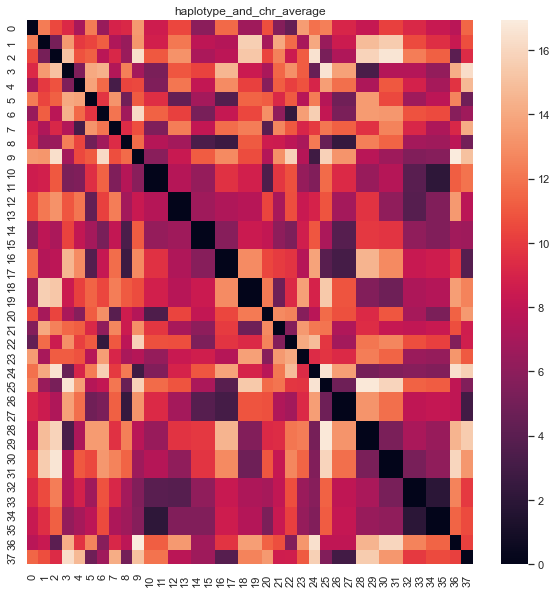

In [118]:
cell1 = data.loc[data.cell_index==70]
cell2 = data.loc[data.cell_index==57]

dist1=get_dist_matrix(cell1, 'haplotype_and_chr_average')
visualize_dist_mat(dist1, title = "haplotype_and_chr_average")

# visualize_dist_mat(dist1, title = "chr_average")


print(get_normalized_matrix_corr(dist1,dist1))

for method in ['haplotype_and_chr_average']:#, 'homolog', 'haplotype']:
    inter_cell = get_inter_cell_corr_matrix(data, method, normalized_corr = True)
    inter_cell[np.where(np.isnan(inter_cell))] = 0 
    inter_cell_distance = 1-abs(inter_cell+inter_cell.T-np.eye(inter_cell.shape[0]))
    np.save("data/inter_cell_{}_normalized_corr_dist_modified_scale.npy".format(method), inter_cell_distance)

# np.diag(inter_cell_distance)

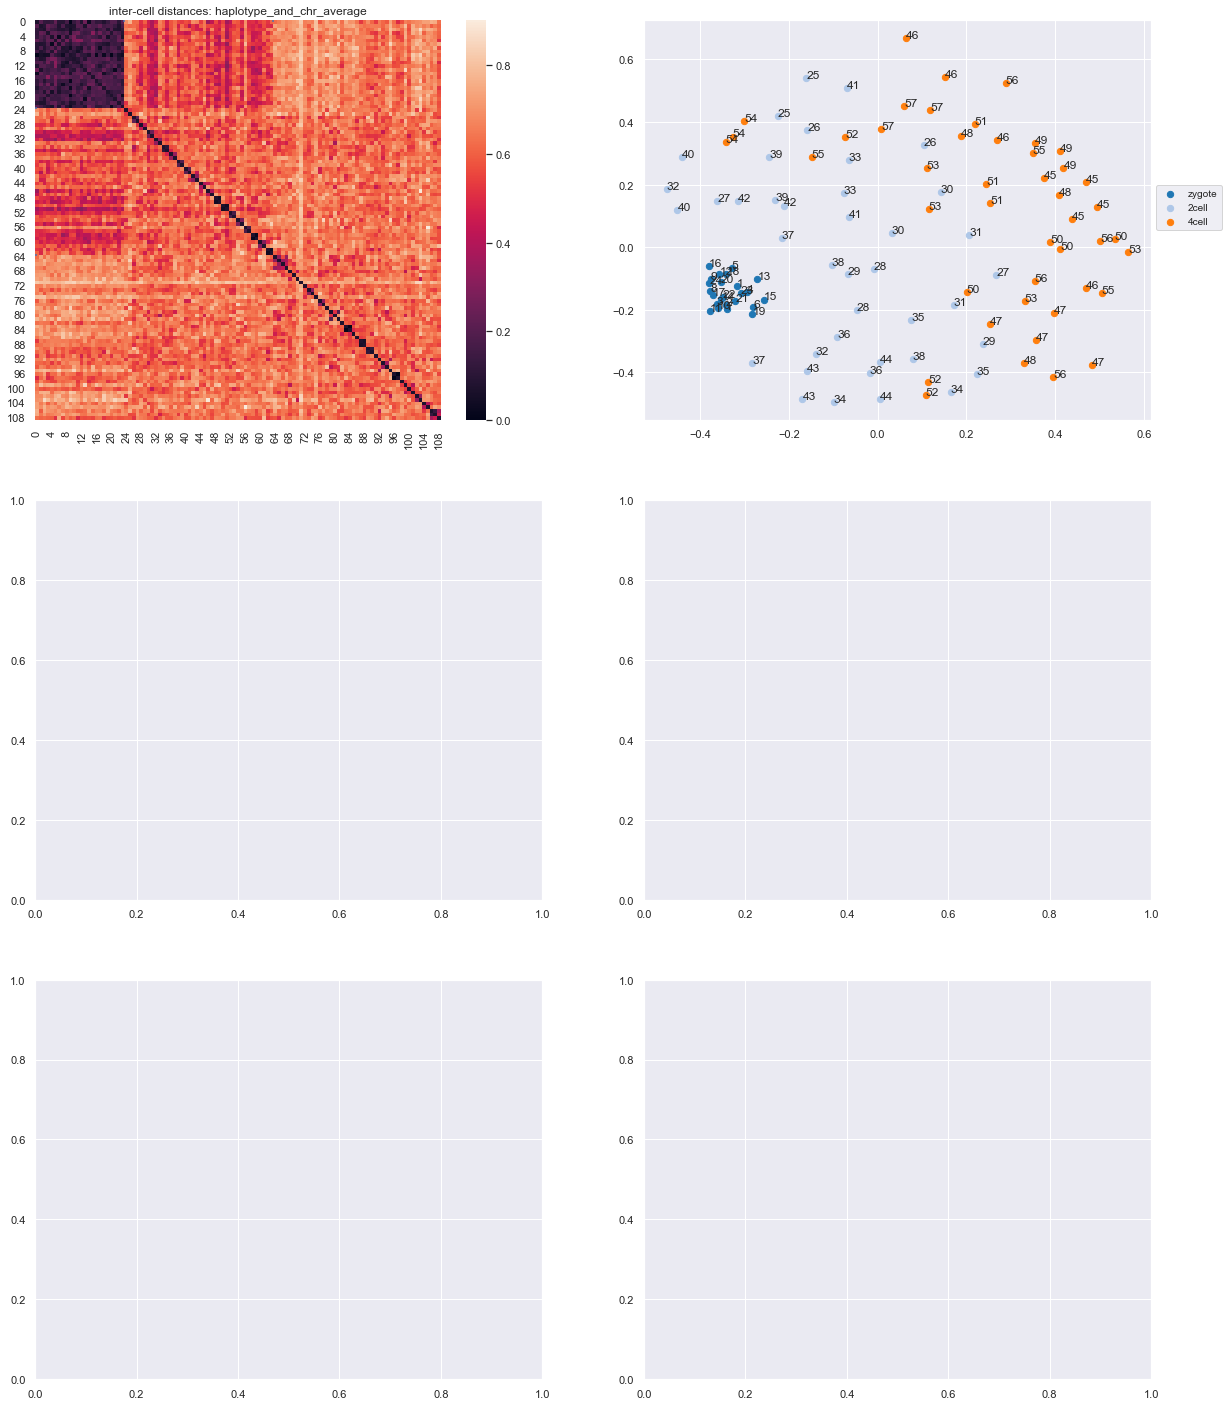

In [122]:

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 25))
inter_cell_methods = ["haplotype_and_chr_average"]#"chr_average", "haplotype", "homolog"]
for i, method in enumerate(inter_cell_methods):
    ########## distance matrix heat map
    inter_cell_distance = np.load("data/inter_cell_{}_normalized_corr_dist_modified_scale.npy".format(method))
#     inter_cell[np.where(np.isnan(inter_cell))] = 0 
#     inter_cell_distance = 1-abs(inter_cell+inter_cell.T-np.eye(inter_cell.shape[0]))
    sns.heatmap(inter_cell_distance, ax = axes[i,0])
    axes[i,0].vlines([24,64], *ax.get_xlim()) #drawing vertical lines separating the stages
    axes[i,0].hlines([24,64], *ax.get_xlim())
    axes[i,0].set_title("inter-cell distances: " + method)
    
    ############# mds visualization
    mds = MDS(dissimilarity='precomputed', random_state=0)
    mds_cells = mds.fit_transform(inter_cell_distance) #shape: 109 x 2
    
#     plt.subplot(3,2,2*(i+1))
    vals = np.arange(0,3)
    embryo_color_dict = dict(zip(['zygote','2cell','4cell'], vals))
    color_list = plt.cm.tab20(vals)

    cmap=plt.get_cmap('tab20')
    for stage in ['zygote','2cell','4cell']:
        cell_indeces = data.loc[data.stage==stage,'cell_index'].unique()
        indeces = [cell_id_to_id[cell_id] for cell_id in cell_indeces]
        color = color_list[embryo_color_dict[stage]]
        axes[i,1].scatter(mds_cells[indeces,0], mds_cells[indeces,1], s = 40, color = color, cmap = cmap, marker = "o",  label= stage)
        for cell_id in cell_indeces:
            embryo_id = data.loc[data.cell_index==cell_id, 'embryo_id'].unique()[0]
            id_ = cell_id_to_id[cell_id]
            axes[i,1].text(mds_cells[id_,0], mds_cells[id_,1], str(embryo_id))
    lgd = axes[i,1].legend(ncol = 1, fontsize=10, bbox_to_anchor = (1,0.6))
#     axes[i,1].xlabel("MDS dim 1")
#     axes[i,1].ylabel("MDS dim 2")
plt.show()
# fig.savefig("figures/inter-cell_all")


In [133]:
inter_cell_distance = np.load("data/inter_cell_chr_average_normalized_corr_dist_modified_scale.npy")
np.diag(inter_cell_distance)
mds = MDS(dissimilarity='precomputed', random_state=0, n_components = 2)
mds_cells = mds.fit_transform(inter_cell_distance) #shape: 109 x 2
mds.stress_

667.8290523366578

Text(0, 0.5, 'MDS dim 2')

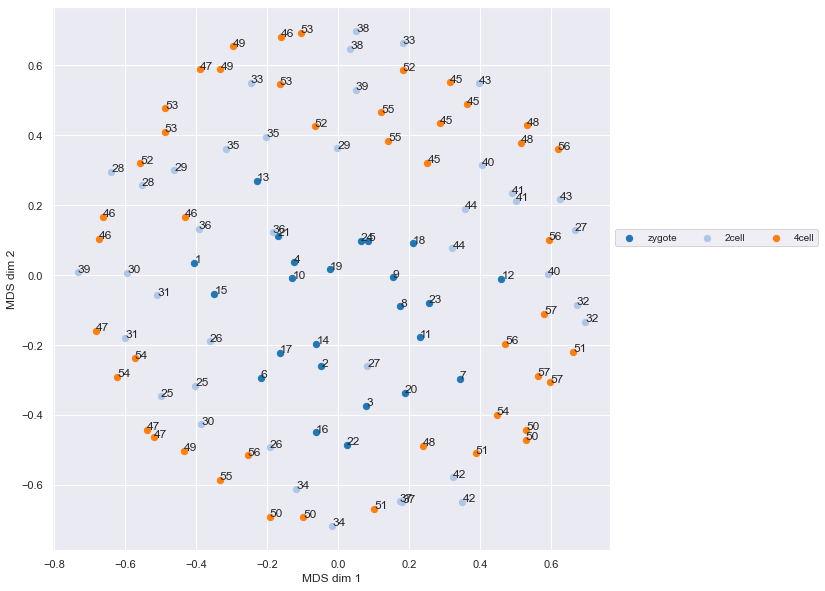

In [134]:
## Creating a color_map dictionary: maps from embryo to a number, then we need to call cmap(dict) to map to color

vals = np.arange(0,3)
embryo_color_dict = dict(zip(['zygote','2cell','4cell'], vals))
color_list = plt.cm.tab20(vals)

fig = plt.figure(figsize = (10,10))
cmap=plt.get_cmap('tab20')
for stage in ['zygote','2cell','4cell']:
    cell_indeces = data.loc[data.stage==stage,'cell_index'].unique()
    indeces = [cell_id_to_id[cell_id] for cell_id in cell_indeces]
    color = color_list[embryo_color_dict[stage]]
    plt.scatter(mds_cells[indeces,0], mds_cells[indeces,1], s = 40, color = color, cmap = cmap, marker = "o",  label= stage)
    for cell_id in cell_indeces:
        embryo_id = data.loc[data.cell_index==cell_id, 'embryo_id'].unique()[0]
        i = cell_id_to_id[cell_id]
        plt.text(mds_cells[i,0], mds_cells[i,1], str(embryo_id))
lgd = plt.legend(ncol = 4, fontsize=10, bbox_to_anchor = (1,0.6))
plt.xlabel("MDS dim 1")
plt.ylabel("MDS dim 2")
# plt.savefig("figures/MDS_haplotype_normalized_corr.png",bbox_extra_artists=(lgd,), bbox_inches='tight')


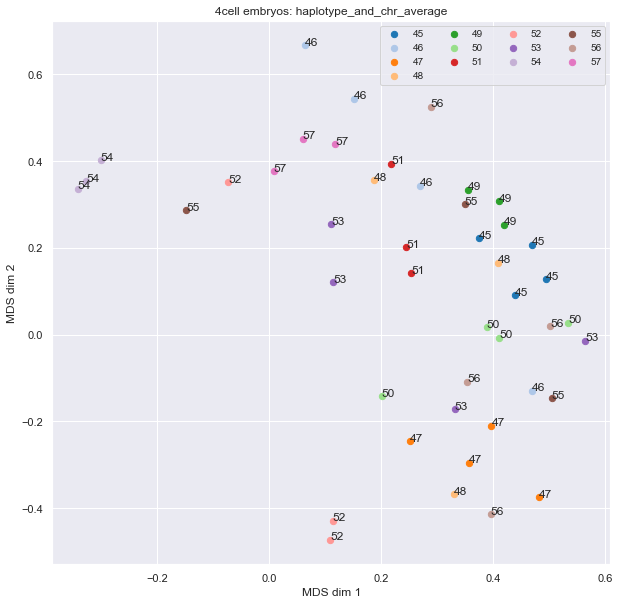

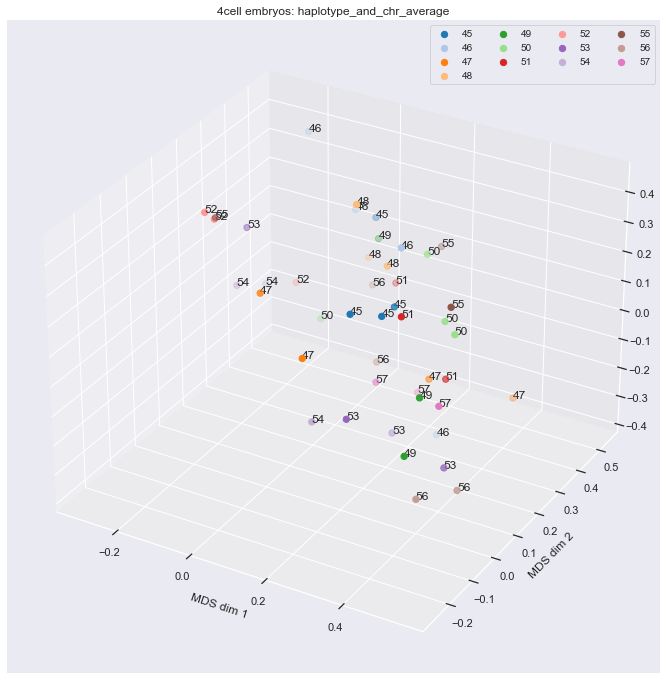

In [124]:
## Creating a color_map dictionary: maps from embryo to a number, then we need to call cmap(dict) to map to color
_4cell = data.loc[data.stage == '4cell']
embryos = np.sort(_4cell.embryo_id.unique())
vals = np.arange(0,len(embryos))
embryo_color_dict = dict(zip(embryos, vals))
color_list = plt.cm.tab20(vals)

# method = "chr_average"
# mds_dim = 3
# inter_cell = np.load("data/inter_cell_{}_normalized_corr.npy".format(method))
# inter_cell[np.where(np.isnan(inter_cell))] = 0 
# inter_cell_distance = 1-abs(inter_cell+inter_cell.T-np.eye(inter_cell.shape[0]))
# mds = MDS(dissimilarity='precomputed', random_state=0, n_components = mds_dim)
# mds_cells = mds.fit_transform(inter_cell_distance) #shape: 109 x 2
for method in ["haplotype_and_chr_average"]:#, "haplotype", "homolog"]:
    inter_cell_distance = np.load("data/inter_cell_{}_normalized_corr_dist_modified_scale.npy".format(method))
#     inter_cell[np.where(np.isnan(inter_cell))] = 0 
#     inter_cell_distance = 1-abs(inter_cell+inter_cell.T-np.eye(inter_cell.shape[0]))
    for mds_dim in [2,3]:
        mds = MDS(dissimilarity='precomputed', random_state=0, n_components = mds_dim)
        mds_cells = mds.fit_transform(inter_cell_distance) #shape: 109 x 2
    
        if mds_dim==2:
            fig = plt.figure(figsize = (10,10))
            cmap=plt.get_cmap('tab20')
            for embryo in embryos:
                cell_indeces = data.loc[data.embryo_id==embryo,'cell_index'].unique()
                indeces = [cell_id_to_id[cell_id] for cell_id in cell_indeces]
                color = color_list[embryo_color_dict[embryo]]
                plt.scatter(mds_cells[indeces,0], mds_cells[indeces,1], s = 40, color = color, cmap = cmap, marker = "o",  label= embryo)
                for i in indeces:
                    plt.text(mds_cells[i,0], mds_cells[i,1], str(embryo))
            lgd = plt.legend(ncol = 4, fontsize=10, bbox_to_anchor = (1,1))
            plt.xlabel("MDS dim 1")
            plt.ylabel("MDS dim 2")
            plt.title("4cell embryos: {}".format(method))
#             plt.savefig("figures/4cell_MDS{}D_{}_normalized_corr_.png".format(mds_dim, method),bbox_extra_artists=(lgd,), bbox_inches='tight')
        else:
            fig = plt.figure(figsize = (12,12))
            ax = fig.add_subplot(projection='3d')
            cmap=plt.get_cmap('tab20')
            for embryo in embryos:
                cell_indeces = data.loc[data.embryo_id==embryo,'cell_index'].unique()
                indeces = [cell_id_to_id[cell_id] for cell_id in cell_indeces]
                color = color_list[embryo_color_dict[embryo]]
                ax.scatter(mds_cells[indeces,0], mds_cells[indeces,1], mds_cells[indeces,2], s = 40, color = color, marker = "o",  label= embryo)
                for i in indeces:
                    ax.text(mds_cells[i,0], mds_cells[i,1], mds_cells[i,2], str(embryo))
            lgd = ax.legend(ncol = 4, fontsize=10, bbox_to_anchor = (1,1))
            ax.set_xlabel("MDS dim 1")
            ax.set_ylabel("MDS dim 2")
            ax.set_title("4cell embryos: {}".format(method))
#             fig.savefig("figures/4cell_MDS{}D_{}_normalized_corr_.png".format(mds_dim, method),bbox_extra_artists=(lgd,), bbox_inches='tight')


In [37]:
cell_indeces = data.loc[data.embryo_id==45,'cell_index'].unique()
ids = [cell_id_to_id[j] for j in cell_indeces]


method = "chr_average"
mds_dim = 2
inter_cell = np.load("data/inter_cell_{}_normalized_corr.npy".format(method))
inter_cell[np.where(np.isnan(inter_cell))] = 0 
inter_cell_distance = 1-abs(inter_cell+inter_cell.T-np.eye(inter_cell.shape[0]))

mds = MDS(dissimilarity='precomputed', random_state=0, n_components = mds_dim)
mds_cells = mds.fit_transform(inter_cell_distance) #shape: 109 x 2

for i in ids:
    for j in range(i,i+4):
        pi = mds_cells[i,:]
        pj = mds_cells[j,:]
        dist = np.sqrt(np.sum(sp.square(pi-pj)))
        print(i,j, dist, inter_cell_distance[i,j])

64 64 0.0 0.1459911865880179
64 65 0.23926632916372612 0.5037999105224431
64 66 0.12046617852130109 0.9769058932662583
64 67 0.07920618476143197 0.3244998085482993
65 65 0.0 0.1459911865880179
65 66 0.11893419748360737 0.34365107570914344
65 67 0.20083430717778555 0.6860774642807139
65 68 0.9271278881071937 0.7871367484289241
66 66 0.0 0.1459911865880179
66 67 0.09282124972704649 0.680091784424538
66 68 0.9862991662551561 0.9336823383388753
66 69 0.7672162598840311 0.8671753866897745
67 67 0.0 0.1459911865880179
67 68 1.0740618580559704 0.8695858495465421
67 69 0.8571392666578639 0.741532377640987
67 70 1.1063675679735 0.9908805908653673


/tmp/ipykernel_9801/3877041022.py:18: DeprecationWarning: scipy.square is deprecated and will be removed in SciPy 2.0.0, use numpy.square instead
  dist = np.sqrt(np.sum(sp.square(pi-pj)))


<AxesSubplot:>

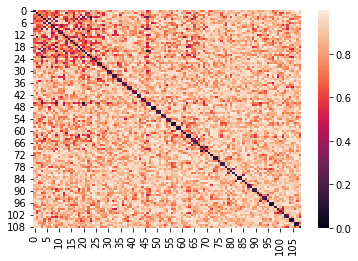

In [41]:

sns.heatmap(inter_cell_distance)

(3920,)


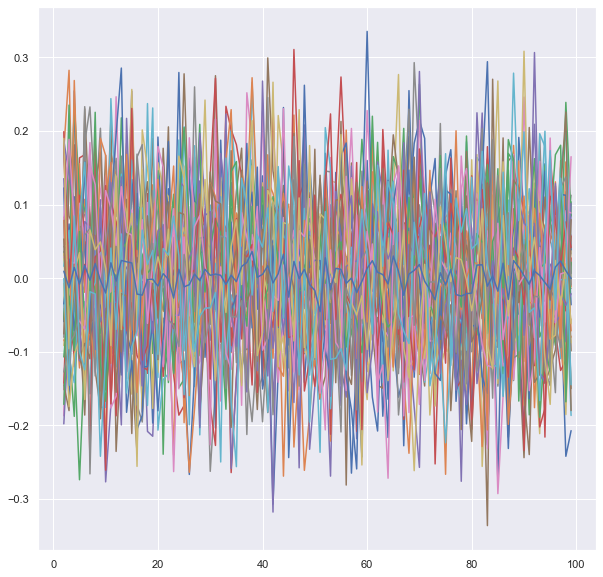

In [135]:
trials = np.array([])
for t in range(40):
    corrs = np.array([])
    for l in range(2,100):
        x = np.random.normal(0,1,(l,l)).reshape(-1,)
        y = np.random.normal(0,1,(l,l)).reshape(-1,) 
        corrs = np.append(corrs,(sp.stats.pearsonr(x,y)[0]) * l/10  )
    plt.plot(np.arange(2,100), corrs)
    trials = np.append(trials, corrs)
print(trials.shape)
trials = trials.reshape(40,-1)
plt.plot(np.arange(2,100), np.mean(trials, axis = 0))

In [71]:
corrs

array([8.61868606e-01, 3.44129341e-01, 1.32746435e-01, 9.57747864e-03,
       1.52523344e-01, 1.02295498e-01, 1.26055936e-01, 9.63093560e-02,
       8.41214670e-02, 3.18785004e-02, 2.98529586e-02, 5.19531584e-02,
       4.04439107e-02, 3.32040797e-02, 5.26538246e-02, 5.95616599e-02,
       6.73947877e-04, 1.30678323e-02, 3.54706758e-02, 8.56219019e-02,
       8.78841017e-03, 4.15999789e-03, 5.63974317e-02, 8.65862681e-03,
       1.25446595e-02, 4.14404669e-02, 5.05679669e-02, 5.03216685e-02,
       3.02330997e-02, 2.41031706e-03, 1.83253557e-02, 3.97987398e-03,
       2.67010398e-02, 2.53395185e-02, 3.01702188e-02, 1.85328196e-03,
       1.01001568e-02, 3.35188972e-02, 1.16004391e-02, 3.40782993e-03,
       2.45540482e-03, 2.18874836e-02, 5.47532810e-03, 4.07057750e-02,
       2.01621824e-02, 2.22560939e-02, 1.52221115e-02, 2.01006214e-02])

In [50]:
inter_cell

array([[nan]])

In [139]:
x1 = np.array([1,2,3])
x2 = np.array([1,3,7])
y1 = np.array([1,2,3,1,2,3])
y2 = np.array([1,3,7,1,3,7])

In [140]:
x_corr = sp.stats.pearsonr(x1,x2)[0]
y_corr = sp.stats.pearsonr(y1,y2)[0]
print(x_corr,y_corr)

0.9819805060619655 0.9819805060619656


In [143]:
np.std(y1)

0.816496580927726

In [31]:
x_corr

0.3086066999241839

In [25]:
y_corr

0.5786913866044946